In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import seaborn as sns
from adjustText import adjust_text

### Pseudo Bulk for each cell population against gestational time

In [2]:
adata = sc.read_h5ad("/home/levinsj/Fetal_dir/CellBenderCorrected/04_annotated/MergedFetalOnly_annotated_all_final.h5ad")

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 65289 × 24409
    obs: 'sample', 'type', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'leiden', 'cellType', 'leiden2', 'cellType2', 'cellType3'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'


In [4]:
cell_identities = {'HK2725': 19.4, 'HK2723': 20.7, 'HK2722': 14.0, 'HK2716': 15.7, 'HK2718': 12.6}
adata.obs["age"] = adata.obs['sample'].map(cell_identities).astype('float')


### PT specific Age related gene changes

In [5]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

PT_subset = adata[adata.obs["cellType"].isin(["PT"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(PT_subset, min_counts=5)

pbs = []
print(PT_subset.obs["age"].value_counts())

for subset in PT_subset.obs["sample"].unique():
    sample_PT = PT_subset[PT_subset.obs["sample"] == subset]
    sample_PT.X = sample_PT.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_PT.X.sum(axis = 0),
                          var = sample_PT.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_PT.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('padj', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/PT_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


19.4    1243
20.7     945
14.0     535
15.7     488
12.6     218
Name: age, dtype: int64


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 154.10 seconds.

Fitting dispersion trend curve...
... done in 0.89 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 110.78 seconds.

Fitting LFCs...
... done in 16.94 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.83 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       1.270081       -0.062918  0.275015 -0.228781  0.819039   
AP006222.2      20.684055        0.007841  0.135521  0.057858  0.953862   
RP11-206L10.3    5.325198        0.138301  0.153113  0.903256  0.366390   
RP11-206L10.2    7.764033       -0.023772  0.119692 -0.198607  0.842570   
RP11-206L10.9    2.774879       -0.102879  0.187696 -0.548118  0.583611   
...                   ...             ...       ...       ...       ...   
AC011043.1      25.700613        0.023505  0.076211  0.308417  0.757765   
AL592183.1     282.311859       -0.063580  0.074814 -0.849841  0.395413   
AC011841.1      22.880947        0.162020  0.076601  2.115120  0.034420   
PNRC2-1          8.883692        0.331770  0.201221  1.648782  0.099192   
SRSF10-1        31.918060        0.007039  0.069026  0.101976  0.918776   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


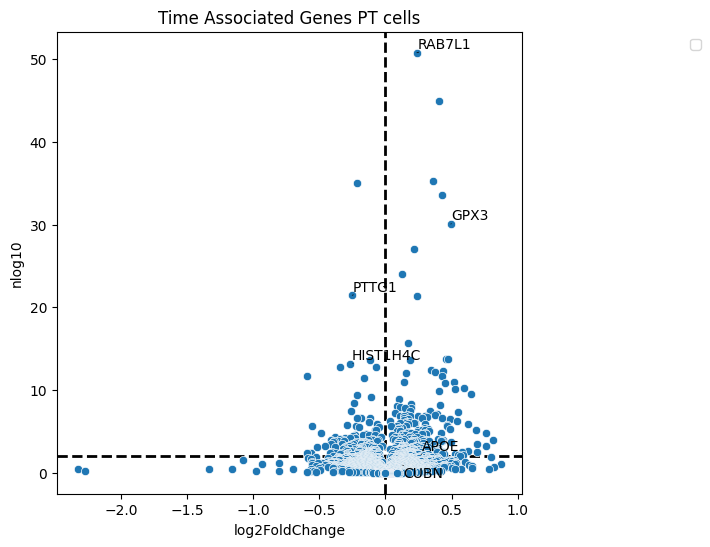

In [6]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)

ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["HIST1H4C", "GPX3", "RAB7L1", "PTTG1", "APOE", "CUBN"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes PT cells')
plt.show()


### LOH genes

In [7]:
LOH_subset = adata[adata.obs["cellType"].isin(["LOH"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(LOH_subset, min_counts=5)

pbs = []
print(LOH_subset.obs["age"].value_counts())

for subset in LOH_subset.obs["sample"].unique():
    sample_LOH = LOH_subset[LOH_subset.obs["sample"] == subset]
    sample_LOH.X = sample_LOH.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_LOH.X.sum(axis = 0),
                          var = sample_LOH.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_LOH.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/LOH_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


14.0    543
19.4    536
15.7    347
20.7    317
12.6    185
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 141.48 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 89.78 seconds.

Fitting LFCs...
... done in 15.67 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.27 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       2.358348        0.344992  0.167904  2.054695  0.039909   
AP006222.2      18.447104        0.022804  0.089822  0.253875  0.799592   
RP11-206L10.3    1.518440        0.107343  0.248486  0.431987  0.665751   
RP11-206L10.2    3.252927        0.164121  0.177963  0.922223  0.356412   
RP11-206L10.9    2.084822       -0.087214  0.211480 -0.412397  0.680049   
...                   ...             ...       ...       ...       ...   
AC011043.1      11.720738       -0.007675  0.106104 -0.072331  0.942338   
AL592183.1     166.540970       -0.049998  0.081538 -0.613187  0.539752   
AC011841.1      13.774503        0.269689  0.107923  2.498901  0.012458   
PNRC2-1          4.860126        0.235627  0.167111  1.410004  0.158538   
SRSF10-1        15.002048        0.143520  0.115854  1.238794  0.215422   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


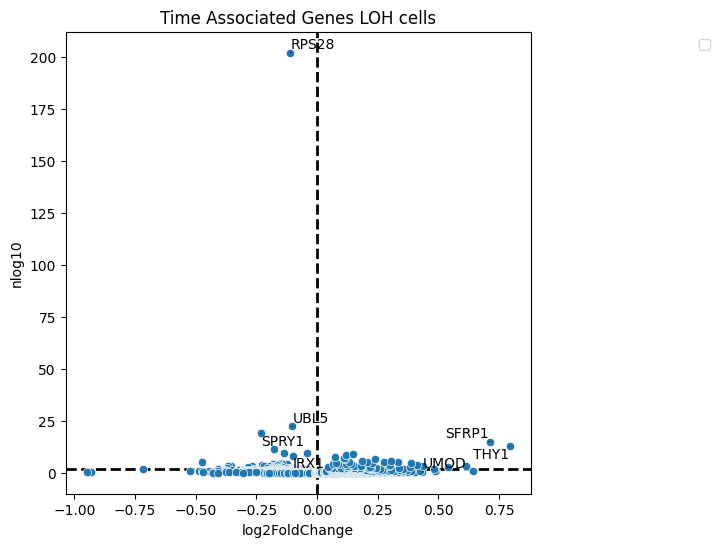

In [8]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["SPRY1", "UBL5", "THY1", "SFRP1", "IRX1", "UMOD", "RPS28"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes LOH cells')
plt.show()

### DCT

In [9]:
DCT_subset = adata[adata.obs["cellType"].isin(["DCT"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(DCT_subset, min_counts=5)

pbs = []
print(DCT_subset.obs["age"].value_counts())

for subset in DCT_subset.obs["sample"].unique():
    sample_DCT = DCT_subset[DCT_subset.obs["sample"] == subset]
    sample_DCT.X = sample_DCT.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_DCT.X.sum(axis = 0),
                          var = sample_DCT.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_DCT.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/DCT_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


19.4    891
14.0    495
15.7    480
20.7    416
12.6    177
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 144.78 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 102.12 seconds.

Fitting LFCs...
... done in 16.02 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.33 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       2.682098        0.221018  0.211478  1.045107  0.295973   
AP006222.2      16.709499        0.000025  0.097169  0.000261  0.999792   
RP11-206L10.3    3.213766        0.112714  0.181885  0.619701  0.535455   
RP11-206L10.2    4.776397       -0.093125  0.149566 -0.622637  0.533523   
RP11-206L10.9    1.901307       -0.003420  0.158310 -0.021604  0.982764   
...                   ...             ...       ...       ...       ...   
AC011043.1      18.196217        0.072793  0.085305  0.853319  0.393483   
AL592183.1     185.537384       -0.059007  0.066942 -0.881469  0.378064   
AC011841.1      15.281726        0.166591  0.057696  2.887380  0.003885   
PNRC2-1          6.340197        0.385385  0.198880  1.937778  0.052650   
SRSF10-1        20.944633       -0.045966  0.059052 -0.778400  0.436333   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


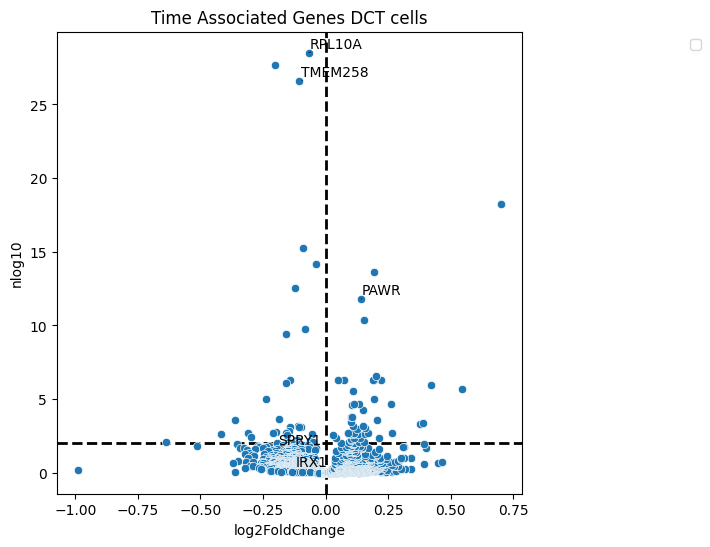

In [10]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["SPRY1", "PAWR", "TMEM258", "IRX1", "RPL10A", "PLCO"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes DCT cells')
plt.show()

### NPC

In [11]:
NPC_subset = adata[adata.obs["cellType"].isin(["NPC"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(NPC_subset, min_counts=5)

pbs = []
print(NPC_subset.obs["age"].value_counts())

for subset in NPC_subset.obs["sample"].unique():
    sample_NPC = NPC_subset[NPC_subset.obs["sample"] == subset]
    sample_NPC.X = sample_NPC.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_NPC.X.sum(axis = 0),
                          var = sample_NPC.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_NPC.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/NPC_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


12.6    1994
14.0    1738
19.4    1552
20.7    1141
15.7    1075
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 159.04 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 130.19 seconds.

Fitting LFCs...
... done in 17.33 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 6.07 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       4.391795       -0.270811  0.182541 -1.483563  0.137925   
AP006222.2      46.792542       -0.137199  0.080549 -1.703313  0.088509   
RP4-669L17.10    1.966618       -0.306807  0.400731 -0.765619  0.443903   
RP11-206L10.3   10.562243       -0.093243  0.122202 -0.763028  0.445447   
RP11-206L10.2   20.964251       -0.070939  0.085499 -0.829713  0.406701   
...                   ...             ...       ...       ...       ...   
AC011043.1      44.163033       -0.051116  0.092834 -0.550618  0.581896   
AL592183.1     663.849243       -0.083824  0.064107 -1.307576  0.191017   
AC011841.1      33.002007        0.129914  0.060142  2.160100  0.030765   
PNRC2-1         31.563757        0.324587  0.099893  3.249344  0.001157   
SRSF10-1       103.128189        0.054439  0.068773  0.791571  0.428611   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


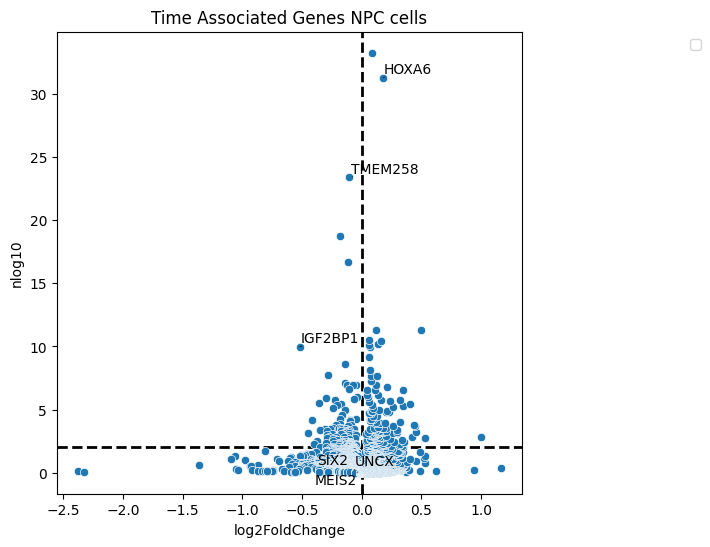

In [12]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["HOXA6", "TMEM258", "IGF2BP1", "SIX2", "UNCX","MEIS2"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes NPC cells')
plt.show()

### Podocyte

In [13]:
Podocyte_subset = adata[adata.obs["cellType"].isin(["Podocyte"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(Podocyte_subset, min_counts=5)

pbs = []
print(Podocyte_subset.obs["age"].value_counts())

for subset in Podocyte_subset.obs["sample"].unique():
    sample_Podocyte = Podocyte_subset[Podocyte_subset.obs["sample"] == subset]
    sample_Podocyte.X = sample_Podocyte.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_Podocyte.X.sum(axis = 0),
                          var = sample_Podocyte.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_Podocyte.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/Podocyte_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


19.4    3404
14.0    3136
15.7    2607
12.6     788
20.7     690
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 147.49 seconds.

Fitting dispersion trend curve...
... done in 0.86 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 123.37 seconds.

Fitting LFCs...
... done in 18.37 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.67 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       2.971267        0.341007  0.241798  1.410298  0.158452   
AP006222.2      52.132366       -0.005321  0.077127 -0.068992  0.944996   
RP4-669L17.10    1.654041       -0.223128  0.302352 -0.737975  0.460530   
RP11-206L10.3    9.621873       -0.035702  0.096694 -0.369230  0.711956   
RP11-206L10.2   21.752594        0.032343  0.064197  0.503806  0.614398   
...                   ...             ...       ...       ...       ...   
AC011043.1      28.509668        0.032688  0.100323  0.325832  0.744552   
AL592183.1     819.619934       -0.023621  0.070685 -0.334175  0.738248   
AC011841.1      27.590647        0.158358  0.096701  1.637600  0.101505   
PNRC2-1         21.904551        0.390111  0.121769  3.203701  0.001357   
SRSF10-1        90.419510        0.161998  0.069855  2.319051  0.020392   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


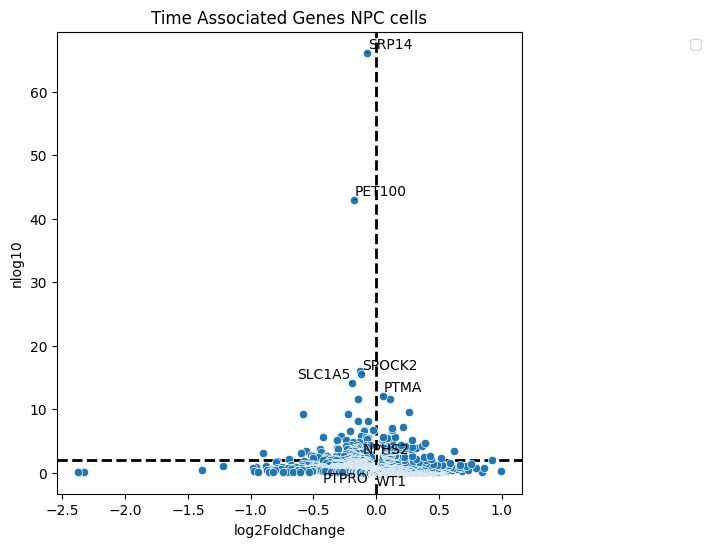

In [14]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["SPOCK2", "SLC1A5", "SRP14","PET100", "PTMA", "NPHS2", "WT1", "PTPRO"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes NPC cells')
plt.show()

### Stroma

In [15]:
Stroma_subset = adata[adata.obs["cellType"].isin(["Stroma"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(Stroma_subset, min_counts=5)

pbs = []
print(Stroma_subset.obs["age"].value_counts())

for subset in Stroma_subset.obs["sample"].unique():
    sample_Stroma = Stroma_subset[Stroma_subset.obs["sample"] == subset]
    sample_Stroma.X = sample_Stroma.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_Stroma.X.sum(axis = 0),
                          var = sample_Stroma.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_Stroma.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/Stroma_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


14.0    4377
15.7    3165
19.4    3128
12.6    2175
20.7    1435
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 162.00 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 141.01 seconds.

Fitting LFCs...
... done in 18.96 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 6.19 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AL627309.1       4.985744       -0.014016  0.168363 -0.083250  0.933653   
AP006222.2     103.680519       -0.038710  0.124516 -0.310884  0.755889   
RP4-669L17.10    2.825467        0.025681  0.219093  0.117214  0.906690   
RP11-206L10.3   14.921414       -0.003529  0.109407 -0.032255  0.974268   
RP11-206L10.2   36.187050       -0.000278  0.071745 -0.003880  0.996904   
...                   ...             ...       ...       ...       ...   
AC011043.1      51.911095       -0.042330  0.092382 -0.458203  0.646807   
AL592183.1     923.219421       -0.028057  0.060852 -0.461075  0.644745   
AC011841.1       6.607139        0.235471  0.161819  1.455150  0.145628   
PNRC2-1         37.845196        0.298458  0.103543  2.882472  0.003946   
SRSF10-1       123.501869        0.069139  0.090221  0.766328  0.443481   

                   padj  
AL627309.1          NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


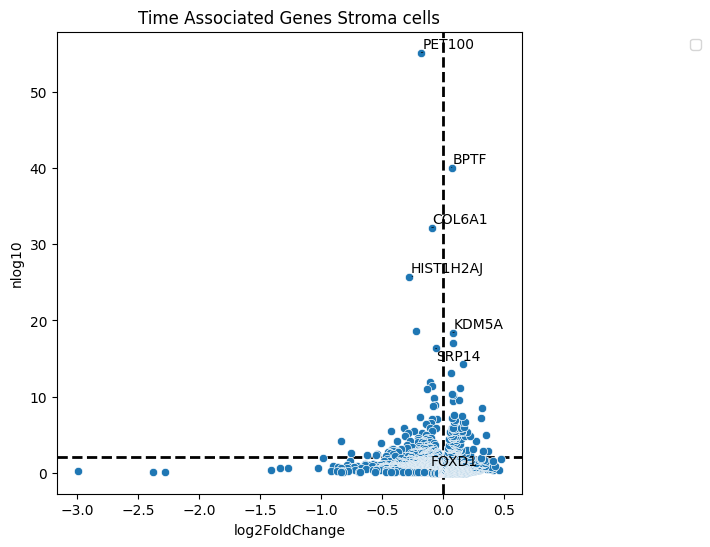

In [16]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["FOXD1", "COL6A1", "SRP14","PET100", "HIST1H2AJ", "BPTF", "KDM5A"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes Stroma cells')
plt.show()

### Endothelium

In [17]:
Endothelium_subset = adata[adata.obs["cellType"].isin(["Endothelium"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(Endothelium_subset, min_counts=5)

pbs = []
print(Endothelium_subset.obs["age"].value_counts())

for subset in Endothelium_subset.obs["sample"].unique():
    sample_Endothelium = Endothelium_subset[Endothelium_subset.obs["sample"] == subset]
    sample_Endothelium.X = sample_Endothelium.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_Endothelium.X.sum(axis = 0),
                          var = sample_Endothelium.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_Endothelium.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/Endothelium_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


15.7    2079
14.0    1526
19.4    1154
12.6     625
20.7     395
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 149.31 seconds.

Fitting dispersion trend curve...
... done in 0.80 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 112.18 seconds.

Fitting LFCs...
... done in 17.24 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.44 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7     1.036267       -0.013812  0.370987 -0.037230  0.970302   
AP006222.2      25.709900        0.055944  0.067110  0.833623  0.404493   
RP4-669L17.10    1.106980        0.171581  0.359514  0.477257  0.633179   
RP11-206L10.3    5.500051        0.064344  0.151837  0.423770  0.671733   
RP11-206L10.2    5.835223       -0.055743  0.154148 -0.361623  0.717633   
...                   ...             ...       ...       ...       ...   
AC011043.1      16.811090       -0.107090  0.098524 -1.086940  0.277063   
AL592183.1     351.115143       -0.004356  0.070529 -0.061755  0.950758   
AC011841.1       3.660285       -0.002035  0.212077 -0.009597  0.992343   
PNRC2-1         13.131708        0.298492  0.153004  1.950881  0.051071   
SRSF10-1        36.522942        0.070940  0.084083  0.843691  0.398842   

                   padj  
RP11-34P13.7        NaN  
AP006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


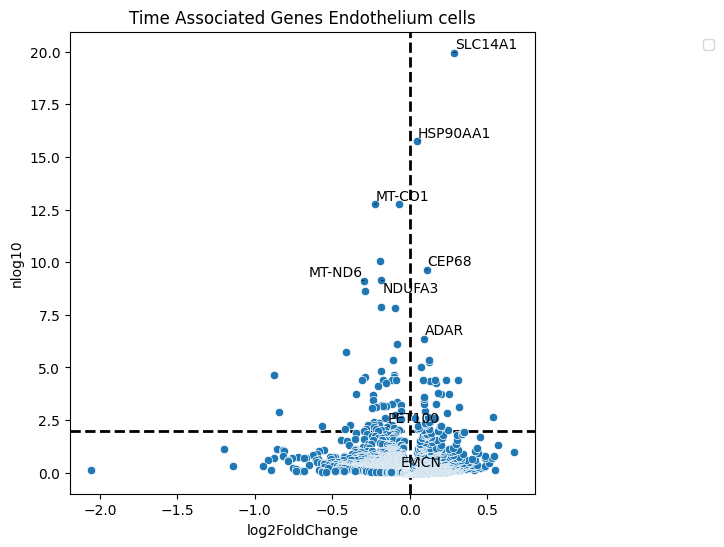

In [18]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["MT-CO1", "NDUFA3", "MT-ND6","PET100", "CEP68", "HSP90AA1", "ADAR", "SLC14A1","EMCN"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes Endothelium cells')
plt.show()

In [19]:
UB_subset = adata[adata.obs["cellType"].isin(["UB_CT"])]

# Find genes with zero expression in all cells and remove them
sc.pp.filter_genes(UB_subset, min_counts=5)

pbs = []
print(UB_subset.obs["age"].value_counts())

for subset in UB_subset.obs["sample"].unique():
    sample_UB = UB_subset[UB_subset.obs["sample"] == subset]
    sample_UB.X = sample_UB.layers["counts"]
    
    rep_adata = sc.AnnData(X = sample_UB.X.sum(axis = 0),
                          var = sample_UB.var[[]])
    
    rep_adata.obs_names = [subset]
    rep_adata.obs["age"] = sample_UB.obs["age"].iloc[0]

    pbs.append(rep_adata)
                                      
pb = sc.concat(pbs)
int_array = pb.X.astype(int)
counts = pd.DataFrame(int_array, columns = pb.var_names)
pb.age = pb.obs["age"].astype(float)

dds = DeseqDataSet(
    counts=counts,
    metadata=pb.obs,
    design_factors="age",
    continuous_factors=["age"]
)
dds.obs["age"] = dds.obs["age"].astype(float)
dds.deseq2()
stat_res = DeseqStats(dds, contrast =(["age","",""]))
stat_res.summary()
ds_sn = stat_res.results_df
ds_sn = ds_sn.sort_values('stat', ascending = True)
print(ds_sn.head(10))
print(ds_sn.tail(10))

ds_sn.to_csv('/home/levinsj/Fetal_dir/DEG/UB_fetal_time_dependent_genes.csv', index=True)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


14.0    440
15.7    328
19.4    268
20.7    216
12.6    156
Name: age, dtype: int64


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 141.77 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

/usr/local/lib/python3.8/dist-packages/pydeseq2/dds.py:425: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 84.58 seconds.

Fitting LFCs...
... done in 15.27 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 5.19 seconds.



Log2 fold change & Wald test p-value: age
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
AP006222.2       8.598516       -0.083213  0.117310 -0.709340  0.478114   
RP11-206L10.3    3.416534        0.075835  0.164874  0.459958  0.645546   
RP11-206L10.2    2.894295        0.107092  0.184997  0.578885  0.562667   
RP11-206L10.9    1.281504        0.082852  0.283842  0.291895  0.770367   
LINC00115        1.550801        0.142778  0.245604  0.581335  0.561015   
...                   ...             ...       ...       ...       ...   
AC011043.1      10.360058        0.009766  0.104798  0.093191  0.925752   
AL592183.1     113.512924       -0.049314  0.071418 -0.690497  0.489881   
AC011841.1       8.189203        0.223645  0.096600  2.315159  0.020604   
PNRC2-1          6.899486        0.380325  0.161297  2.357917  0.018378   
SRSF10-1        14.756253       -0.051941  0.104285 -0.498070  0.618435   

                   padj  
AP006222.2     0.881850  
RP11-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


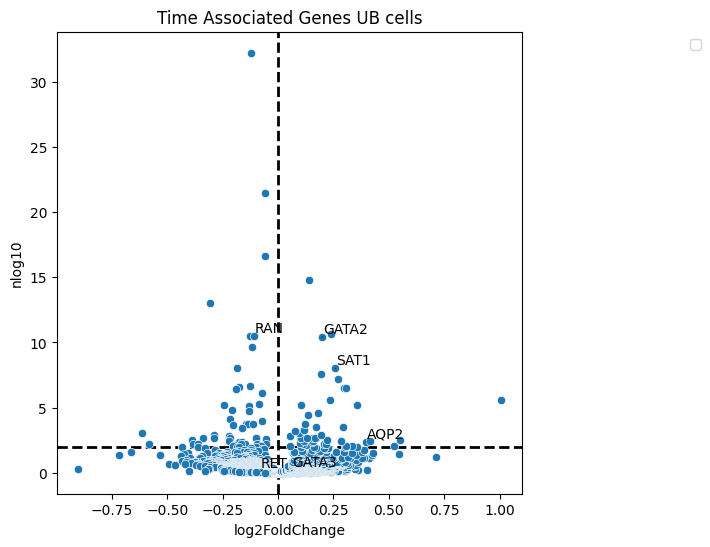

In [20]:
ds_sn["nlog10"] = -np.log10(ds_sn["padj"])

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x="log2FoldChange", y="nlog10",  data=ds_sn)
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(0, zorder = 0, c = "k", lw = 2, ls = "--")

plt.legend(loc = 1, bbox_to_anchor = (1.4,1))

texts = []
for i in range(len(ds_sn)):
  if ds_sn.index[i] in ["RET", "AQP2","RAN","SAT1","GATA3","GATA2"]:
    texts.append(plt.text(x= ds_sn.iloc[i].log2FoldChange, y=ds_sn.iloc[i].nlog10, s = ds_sn.index[i]))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))
plt.title('Time Associated Genes UB cells')
plt.show()